In [12]:
# from agent.scrape import scrape_pandas_website
# %load_ext autoreload
# %autoreload 2
# scrape_pandas_website()

In [7]:
from agent.database import build_docs_metadata

docs,metadata = build_docs_metadata()

In [8]:
len(docs),len(metadata)

(1938, 1938)

In [9]:
docs[608]

'Return the day of the year.'

In [10]:
metadata[608]

{'function_name': 'Timestamp.day_of_year',
 'function_url': 'https://pandas.pydata.org/docs/reference/api/pandas.Timestamp.day_of_year.html#pandas.Timestamp.day_of_year',
 'full_function': 'Timestamp.day_of_year#',
 'function_calling': '{}',
 'parent': 'pandas arrays, scalars, and data types',
 'sub_level_name': 'Objects',
 'sub_level_trail': 'pandas arrays, scalars, and data types',
 'function_trail': 'pandas arrays, scalars, and data types-->Objects'}

In [11]:
docs[276]

'Returns numpy array of datetime.time objects. The time part of the Timestamps.   For Series: For DatetimeIndex:'

In [12]:
metadata[1340]

{'function_name': 'QuarterBegin.rule_code',
 'function_url': 'https://pandas.pydata.org/docs/reference/api/pandas.tseries.offsets.QuarterBegin.rule_code.html#pandas.tseries.offsets.QuarterBegin.rule_code',
 'full_function': 'QuarterBegin.rule_code#',
 'function_calling': '{}',
 'parent': 'Date offsets',
 'sub_level_name': 'QuarterBegin',
 'sub_level_trail': 'Date offsets',
 'function_trail': 'Date offsets-->QuarterBegin'}

In [14]:
metadata[-100]

{'function_name': 'Styler.concat(other)',
 'function_url': 'https://pandas.pydata.org/docs/reference/api/pandas.io.formats.style.Styler.concat.html#pandas.io.formats.style.Styler.concat',
 'full_function': 'Styler.concat(other)',
 'function_calling': "{'name': 'pandas.io.formats.style.Styler.concat', 'descriptions': 'Append another Styler to combine the output into a single table. New in version 1.5.0.', 'parameters': {'type': 'object', 'properties': {'other': {'type': 'Styler', 'description': 'Styler. The other Styler object which has already been styled and formatted. The\\ndata for this Styler must have the same columns as the original, and the\\nnumber of index levels must also be the same to render correctly.\\n'}}, 'required': []}}",
 'parent': 'Style',
 'sub_level_name': 'Style application',
 'sub_level_trail': 'Style',
 'function_trail': 'Style-->Style application'}

In [9]:
num_words = [len(doc.split(" ")) for doc in docs]

In [11]:
docs[10]

'ExcelFile.sheet_names'

<BarContainer object of 1944 artists>

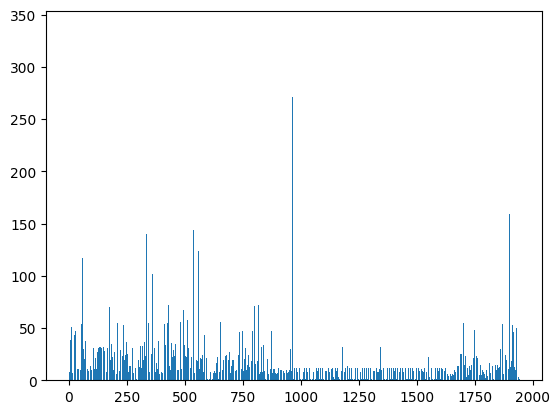

In [13]:
import matplotlib.pyplot as plt

plt.bar([i for i in range(len(docs))],num_words)

In [1]:
from agent.database import build_database
from dotenv import load_dotenv,find_dotenv
%load_ext autoreload
%autoreload 2
load_dotenv(find_dotenv(),override=True)

True

In [2]:
import os
# build_database(docs,metadata,os.environ['OPENAI_API_KEY'])

In [3]:
from agent.database import load_database
import os

pandas_collection = load_database(os.environ['OPENAI_API_KEY'])

In [4]:
# from agent.dspy_agent import PandasAgentChroma
# %load_ext autoreload
# %autoreload 2

In [20]:
import dspy
from agent.utils import *
import chromadb.utils.embedding_functions as embedding_functions
from langchain_community.retrievers import BM25Retriever
from langchain.schema import Document

class FirstSecondLevel(dspy.Signature):
    """You are given a list of keys and their corresponding description separated by semicolon in the format keys: description.
    Based on the query, you have to classify the question to one of the key or keys that is relevant to the question.
    Be precise and output only the relevant key or keys and don't output their descriptions.
    Don't include any other information other than the relevant keys and DON'T answer None or N/A"""

    query = dspy.InputField(prefix="Query which you need to classify: ", format=str)
    keys_values = dspy.InputField(prefix="Keys and Values: ", format=str)
    output = dspy.OutputField(
        prefix="Relevant Key(s): ",
        format=str,
        desc="relevant keys separated by semicolon",
    )

emb_fn = embedding_functions.OpenAIEmbeddingFunction(
    api_key=os.environ["OPENAI_API_KEY"],
    model_name="text-embedding-3-small",
)
llm = dspy.OpenAI(
    model="gpt-3.5-turbo-0125", max_tokens=512
)
dspy.settings.configure(lm=llm)
class PandasAgentBM25(dspy.Module):
    def __init__(self, collection):
        super().__init__()
        self.collection = collection
        self.firstSecondLevel = dspy.Predict(FirstSecondLevel)
        all_docs = self.collection.get()
        self.langchain_docs = [Document(page_content=doc,metadata=meta) for doc,meta in zip(all_docs['documents'],all_docs['metadatas'])]


    def __call__(self, *args, **kwargs):
        return super().__call__(*args, **kwargs)

    def BM25RetrieverLangchain(
        self, query: str, node_type: str = "parent_node", trail_where_clause: dict = {}
    ):

        assert node_type in [
            "parent_node",
            "function_node",
            "sub_level_node",
        ], "type must be 'parent_node' or 'function_node' or 'sub_level_node'"
        if node_type != "parent_node" and trail_where_clause == {}:
            raise ValueError("trail_where_clause must be a dict for function type")

        if node_type == "parent_node":
            bm25_retriever = BM25Retriever.from_documents(
                self.langchain_docs, k=3, preprocess_func=(lambda x: x.lower())
            )
            parent_bm25_docs = bm25_retriever.invoke(query.lower())
            return parent_bm25_docs
        else:
            function_level = self.collection.get(
                where=trail_where_clause
            )
            function_langchain_docs = []
            for doc, metadata in zip(
                function_level["documents"], function_level["metadatas"]
            ):
                function_langchain_docs.append(
                    Document(page_content=doc, metadata=metadata)
                )
            if node_type == "function_node":
                k = 1
            else:
                k = 5
            bm25_retriever = BM25Retriever.from_documents(
                function_langchain_docs, k=k, preprocess_func=(lambda x: x.lower())
            )
            bm25_docs = bm25_retriever.invoke(query.lower())
            return bm25_docs

    def forward(self, query: str):
        parent_bm25_docs = self.BM25RetrieverLangchain(query=query)
        parent_level_str = ""
        for parent_doc in parent_bm25_docs:
            parent_level_str += (
                f"{parent_doc.metadata['parent']}: {parent_doc.page_content}\n\n"
            )

        parent_level_answer = self.firstSecondLevel(
            query=query, keys_values=parent_level_str
        ).output
        print(parent_level_str)
        print(parent_level_answer)
        trail_list = parent_level_answer.split(";")
        trail_list = list(set(trail_list))
        trail_list_pairs = generate_pairs_recursive([trail_list])

        trail_where_clause = get_trail_list_pairs(trail_list_pairs, "sub_level_trail")

        sub_level_docs = self.BM25RetrieverLangchain(query,"sub_level_node",trail_where_clause)

        sub_level_str = ""
        for sub_level in sub_level_docs:
            # if sub_level_docs in sub_level_str:
            #     continue
            function_level_metadata = sub_level.metadata
            sub_level_str += f"{function_level_metadata['parent']}#{function_level_metadata['sub_level_name']}: {sub_level.page_content}\n\n"
        print(sub_level_str)
        sub_level_answer = self.firstSecondLevel(
            query=query, keys_values=sub_level_str
        ).output
        print(sub_level_answer)
        sub_level_list = sub_level_answer.split(";")
        sub_level_list = [sla.split("#")[-1] for sla in sub_level_list]
        sub_level_list = list(set(sub_level_list))
        function_list = generate_pairs_recursive([trail_list_pairs, sub_level_list])
        function_where_clause = get_trail_list_pairs(function_list, "function_trail")
        print(function_where_clause)
        functions = self.BM25RetrieverLangchain(query,"function_node",function_where_clause)
        return functions[0].metadata
pandas_agent = PandasAgentBM25(pandas_collection)
pandas_agent("How to impute values?")

Date offsets: Standard kind of date increment used for a date range. Works exactly like the keyword argument form of relativedelta. Note that the positional argument form of relativedelata is not supported. Use of the keyword n is discouraged– you would be better off specifying n in the keywords you use, but regardless it is there for you. n is needed for DateOffset subclasses. DateOffset works as follows. Each offset specify a set of dates that conform to the DateOffset. For example, Bday defines this set to be the set of dates that are weekdays (M-F). To test if a date is in the set of a DateOffset dateOffset we can use the is_on_offset method: dateOffset.is_on_offset(date). If a date is not on a valid date, the rollback and rollforward methods can be used to roll the date to the nearest valid date before/after the date. DateOffsets can be created to move dates forward a given number of valid dates. For example, Bday(2) can be added to a date to move it two business days forward. If 

{'full_function': 'Series.dropna(*, axis=0, inplace=False, how=None, ignore_index=False)',
 'function_calling': "{'name': 'pandas.Series.dropna', 'descriptions': 'Return a new Series with missing values removed. See the User Guide for more on which values are\\nconsidered missing, and how to work with missing data.', 'parameters': {'type': 'object', 'properties': {'axis': {'type': 'string', 'enum': ['0 or index'], 'description': '{0 or ‘index’}. Unused. Parameter needed for compatibility with DataFrame.\\n'}, 'inplace': {'type': 'boolean', 'description': 'bool, default False. If True, do operation inplace and return None.\\n'}, 'how': {'type': 'string', 'description': 'str, optional. Not in use. Kept for compatibility.\\n'}, 'ignore_index': {'type': 'boolean', 'description': 'bool, default False. If True, the resulting axis will be labeled 0, 1, …, n - 1.\\n\\nNew in version 2.0.0.\\n\\n'}}, 'required': []}}",
 'function_name': 'Series.dropna(*[,\xa0axis,\xa0inplace,\xa0how,\xa0...])',

In [21]:
pandas_agent("How to pivot a dataframe?")

Date offsets: Standard kind of date increment used for a date range. Works exactly like the keyword argument form of relativedelta. Note that the positional argument form of relativedelata is not supported. Use of the keyword n is discouraged– you would be better off specifying n in the keywords you use, but regardless it is there for you. n is needed for DateOffset subclasses. DateOffset works as follows. Each offset specify a set of dates that conform to the DateOffset. For example, Bday defines this set to be the set of dates that are weekdays (M-F). To test if a date is in the set of a DateOffset dateOffset we can use the is_on_offset method: dateOffset.is_on_offset(date). If a date is not on a valid date, the rollback and rollforward methods can be used to roll the date to the nearest valid date before/after the date. DateOffsets can be created to move dates forward a given number of valid dates. For example, Bday(2) can be added to a date to move it two business days forward. If 

{'full_function': 'DataFrame.__add__(other)',
 'function_calling': "{'name': 'pandas.DataFrame.__add__', 'descriptions': 'Get Addition of DataFrame and other, column-wise. Equivalent to DataFrame.add(other).', 'parameters': {'type': 'object', 'properties': {'other': {'type': 'scalar, sequence, Series, dict or DataFrame', 'description': 'scalar, sequence, Series, dict or DataFrame. Object to be added to the DataFrame.\\n'}}, 'required': []}}",
 'function_name': 'DataFrame.__add__(other)',
 'function_trail': 'DataFrame-->Binary operator functions',
 'function_url': 'https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.__add__.html#pandas.DataFrame.__add__',
 'parent': 'DataFrame',
 'sub_level_name': 'Binary operator functions',
 'sub_level_trail': 'DataFrame'}

In [6]:
pandas_collection.get(
    where={'$or': [{'function_trail': {'$eq': 'Series--> Series#Missing data handling'}}, {'function_trail': {'$eq': 'Series-->DataFrame#Missing data handling'}}, {'function_trail': {'$eq': 'DataFrame--> Series#Missing data handling'}}, {'function_trail': {'$eq': 'DataFrame-->DataFrame#Missing data handling'}}]}
)

{'ids': [],
 'embeddings': None,
 'metadatas': [],
 'documents': [],
 'uris': None,
 'data': None}

In [16]:
for meta in metadata:
    if meta['function_trail'].startswith('Series'):
        print(meta['function_trail'])

Series-->Constructor
Series-->Attributes
Series-->Attributes
Series-->Attributes
Series-->Attributes
Series-->Attributes
Series-->Attributes
Series-->Attributes
Series-->Attributes
Series-->Attributes
Series-->Attributes
Series-->Attributes
Series-->Attributes
Series-->Attributes
Series-->Attributes
Series-->Attributes
Series-->Attributes
Series-->Conversion
Series-->Conversion
Series-->Conversion
Series-->Conversion
Series-->Conversion
Series-->Conversion
Series-->Conversion
Series-->Conversion
Series-->Conversion
Series-->Conversion
Series-->Indexing, iteration
Series-->Indexing, iteration
Series-->Indexing, iteration
Series-->Indexing, iteration
Series-->Indexing, iteration
Series-->Indexing, iteration
Series-->Indexing, iteration
Series-->Indexing, iteration
Series-->Indexing, iteration
Series-->Indexing, iteration
Series-->Indexing, iteration
Series-->Binary operator functions
Series-->Binary operator functions
Series-->Binary operator functions
Series-->Binary operator functions
